### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

2025-05-17 09:18:32.549999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747473512.921990      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747473513.059010      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import seaborn as sns

### Dataset

In [4]:
df = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json",lines= True )

### Preprocessing Data

In [5]:
df = df[['headline', 'category']]

In [6]:
df.dropna(inplace=True)


In [7]:
df = df[df['category'] != '']

In [8]:
df.head()

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


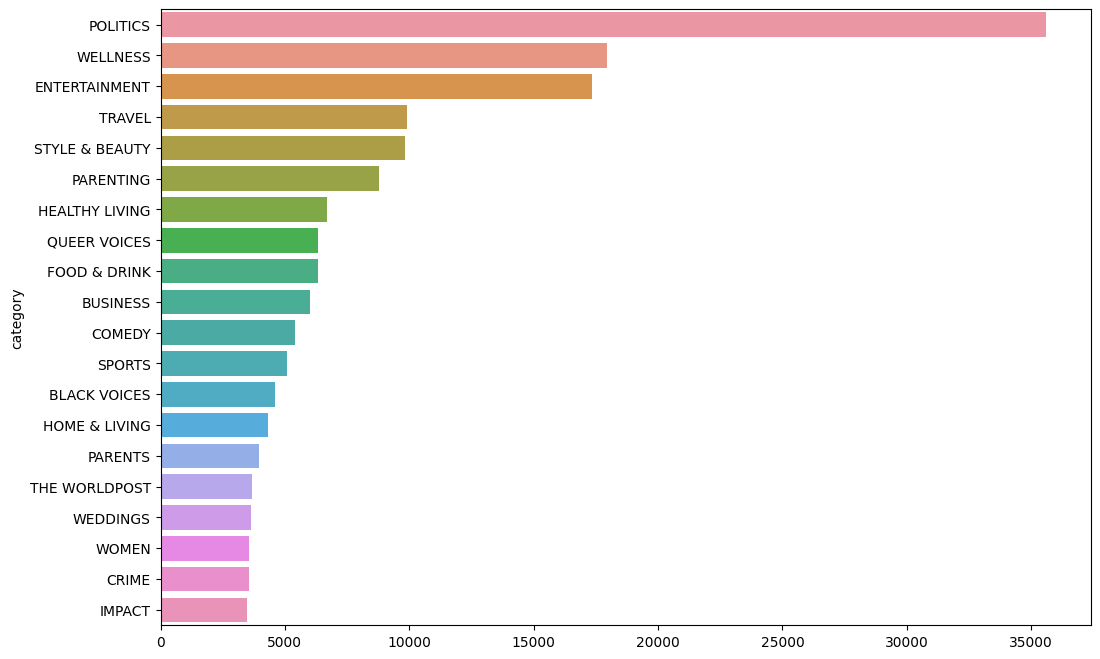

In [9]:
plt.figure(figsize= (12,8))
top = df['category'].value_counts().nlargest(20)
sns.barplot(y=top.index, x= top.values)
plt.show()

In [10]:
label_encoder= LabelEncoder()


In [11]:
df['label'] = label_encoder.fit_transform(df['category'])

In [12]:
num_classes = len(label_encoder.classes_)

### Tokenization

In [13]:
df.head()

,headline,category,label
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,35
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,35
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,5
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,22
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,35


In [14]:
max_length = 25
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['headline'])

In [15]:
sequences = tokenizer.texts_to_sequences(df['headline'])

In [16]:
word_index = tokenizer.word_index

### Padding

In [17]:
x = pad_sequences(sequences, maxlen=max_length)

In [18]:
y = tf.keras.utils.to_categorical(df['label'], num_classes=num_classes)

In [19]:
print(x)

[[   0    0    0 ...    6 3684 1001]
 [   0    0    0 ... 5649    9   25]
 [   0    0    0 ... 7116  970 1820]
 ...
 [   0    0    0 ...   53   70  849]
 [   0    0    0 ... 4889    6 6494]
 [   0    0    0 ... 1558  519    2]]


### Train Test Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, test_size= 0.2, random_state= 42)

### Model Architecture and Training

In [21]:
model = Sequential()
model.add(Embedding(input_dim= 10000, output_dim= 100, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-17 09:21:19.095294: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

Epoch 1/5
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 99s 77ms/step - accuracy: 0.2361 - loss: 3.0274 - val_accuracy: 0.4208 - val_loss: 2.1970
Epoch 2/5
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - accuracy: 0.4484 - loss: 2.1063 - val_accuracy: 0.4957 - val_loss: 1.9083
Epoch 3/5
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 95s 80ms/step - accuracy: 0.5172 - loss: 1.8179 - val_accuracy: 0.5220 - val_loss: 1.7909
Epoch 4/5
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy: 0.5510 - loss: 1.6691 - val_accuracy: 0.5329 - val_loss: 1.7506
Epoch 5/5
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 92s 78ms/step - accuracy: 0.5687 - loss: 1.5843 - val_accuracy: 0.5390 - val_loss: 1.7335


### Model Evaluation

In [26]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5447 - loss: 1.7222
Test Accuracy: 0.5433


In [28]:
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step


In [29]:
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

          ARTS       0.24      0.19      0.21       293
ARTS & CULTURE       0.31      0.07      0.12       275
  BLACK VOICES       0.36      0.31      0.33       889
      BUSINESS       0.42      0.40      0.41      1216
       COLLEGE       0.46      0.22      0.30       202
        COMEDY       0.54      0.39      0.45      1022
         CRIME       0.44      0.54      0.48       713
CULTURE & ARTS       0.46      0.23      0.31       202
       DIVORCE       0.75      0.60      0.67       664
     EDUCATION       0.45      0.13      0.21       209
 ENTERTAINMENT       0.55      0.72      0.62      3419
   ENVIRONMENT       0.43      0.20      0.27       313
         FIFTY       0.00      0.00      0.00       263
  FOOD & DRINK       0.59      0.72      0.65      1270
     GOOD NEWS       0.48      0.04      0.08       270
         GREEN       0.32      0.30      0.31       532
HEALTHY LIVING       0.17      0.00      0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualization

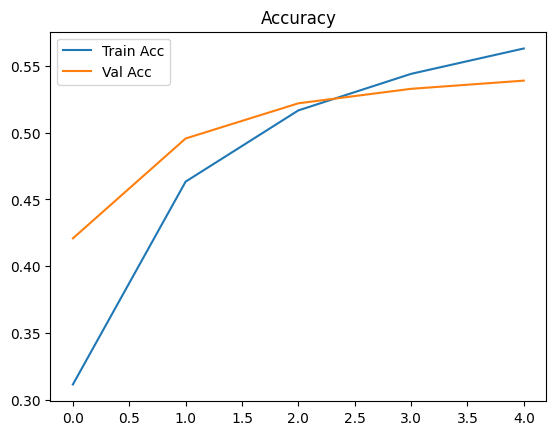

In [31]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

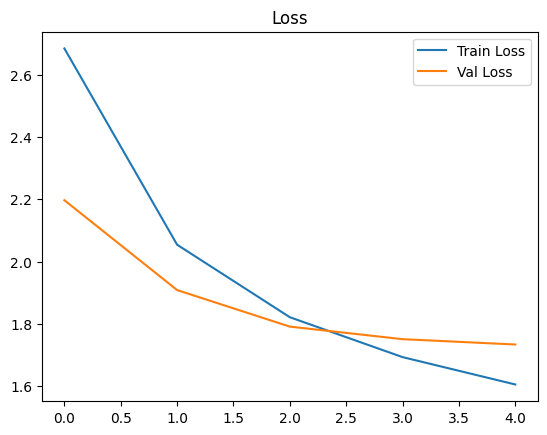

In [32]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()